In [4]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
import os
import cv2  # or use PIL for image loading
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, optimizers, Model
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [6]:
def preprocess_image(img):
    val = (img.astype('float32') - 127.5) / 127.5
    return val

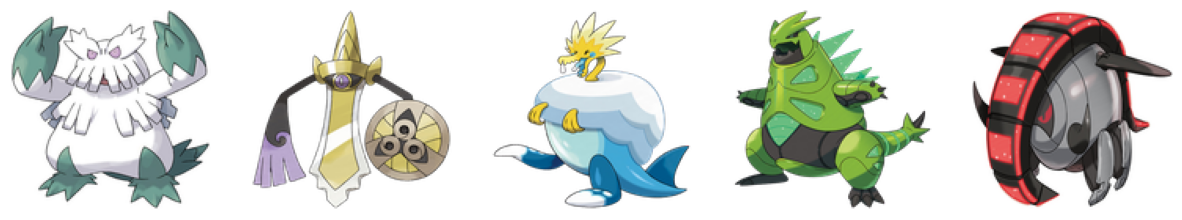

In [7]:

def load_and_preprocess_images(folder_path):
    # List all files in the folder
    image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.jpg', '.jpeg', '.png'))]

    num_samples = 5

    # Display sample images
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Read the image
        img = plt.imread(image_files[i])
    
        # Plot the image
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.show()
    
    # Load and preprocess each image
    images = []
    for file_path in image_files:
        img = cv2.imread(file_path)  # Load image using OpenCV
        # Perform preprocessing such as resizing, normalization, etc.
        img = preprocess_image(img)
        images.append(img)
    images = np.stack(images, axis=0)
    return images

# Load and preprocess images from a folder
folder_path = 'D:/NGUYEN/CV_ML/Pokemon128'
images = load_and_preprocess_images(folder_path)

In [8]:
print(images.shape)

(2374, 128, 128, 3)


In [9]:
# Define generator network
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(100,)),
        layers.Dense(8*8*256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model


In [10]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      5

(4, 128, 128, 3)


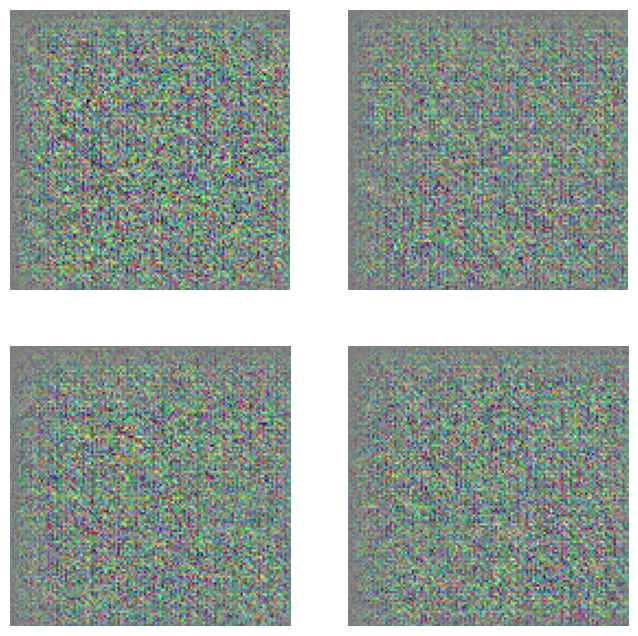

In [11]:
noise = np.random.randn(4, 100)

# Generate images using the generator
predictions = generator(noise, training=False)

print(predictions.shape)

# Plot the generated images
fig = plt.figure(figsize=(8, 8))

for i in range(predictions.shape[0]):
    # Scale pixel values to range [0, 255] for each channel
    img = (predictions[i, :, :, :] * 12700.5 + 127.5).numpy().astype(np.uint8)
    
    # Assuming image shape is (height, width, channels)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [12]:
def build_discriminator(d_dim=16):
    model = tf.keras.Sequential([
        layers.Conv2D(d_dim, (4, 4), strides=(2, 2), padding='same', input_shape=(128,128,3)),
        layers.LayerNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2D(d_dim*2, (4, 4), strides=(2, 2), padding='same'),
        layers.LayerNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2D(d_dim*4, (4, 4), strides=(2, 2), padding='same'),
        layers.LayerNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2D(d_dim*8, (4, 4), strides=(2, 2), padding='same'),
        layers.LayerNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2D(d_dim*16, (4, 4), strides=(2, 2), padding='same'),
        layers.LayerNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2D(1, (4, 4), strides=(1, 1), padding='valid')
    ])
    return model

In [13]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        784       
                                                                 
 layer_normalization (LayerN  (None, 64, 64, 16)       32        
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        8224      
                                                                 
 layer_normalization_1 (Laye  (None, 32, 32, 32)       64        
 rNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 32)       

In [14]:
# Define GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = layers.Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    model = Model(gan_input, gan_output)
    return model

In [15]:
# Build networks
gan = build_gan(generator, discriminator)

In [16]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [17]:
def train(images, epochs, batch_size):
    gen_losses = []
    disc_losses = []
    
    for epoch in range(epochs):
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        num_batches = 0
        
        for image_batch in images:
            noise = tf.random.normal([batch_size, 100])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(noise, training=True)

                real_output = discriminator(image_batch, training=True)
                fake_output = discriminator(generated_images, training=True)

                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            num_batches += 1

        avg_gen_loss = epoch_gen_loss / num_batches
        avg_disc_loss = epoch_disc_loss / num_batches
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        print(f"Epoch {epoch+1}, Generator Loss: {avg_gen_loss}, Discriminator Loss: {avg_disc_loss}")

        # Generate and save sample images every 10 epochs
        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
            viz(gen_losses, disc_losses)
    

In [18]:
def viz(gen_losses, disc_losses):
# Plot the generator and discriminator losses
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Losses Over Epochs')
    plt.show()

In [19]:
# Function to generate and save sample images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        # Scale pixel values to range [0, 255] for each channel
        img = (predictions[i, :, :, :] * 127.5 + 127.5).numpy().astype(np.uint8)
        
        plt.subplot(8, 8, i+1)
        plt.imshow(img)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [20]:
epochs = 2000
batch_size = 32

# Load and preprocess the dataset
# Assuming `images` is your dataset

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(len(images)).batch(batch_size)

# Seed for generating sample images
seed = tf.random.normal([64, 100])

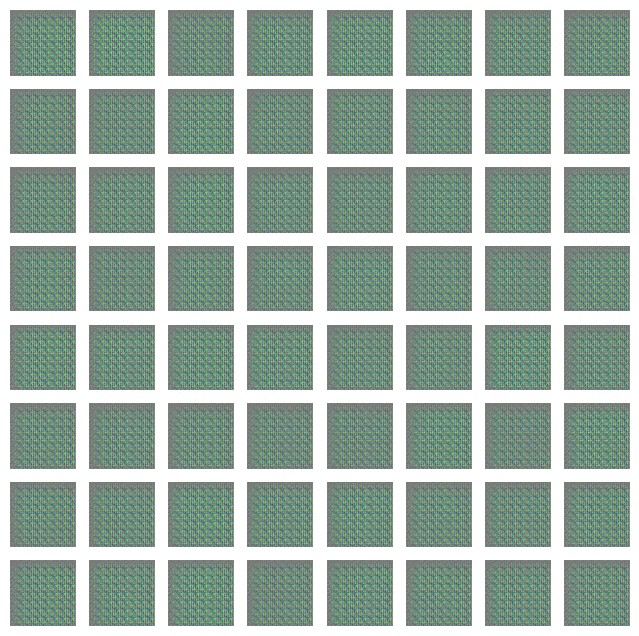

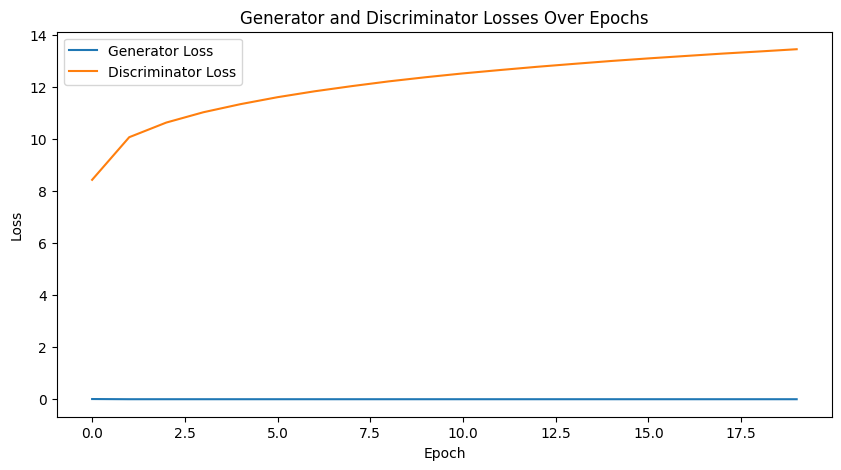

Epoch 21, Generator Loss: 1.8996186099684564e-06, Discriminator Loss: 13.533061981201172
Epoch 22, Generator Loss: 1.7587044567335397e-06, Discriminator Loss: 13.609716415405273


In [ ]:
# Train the GAN
train(dataset, epochs, batch_size)